In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


In [8]:
data.Region_Code.nunique()

53

**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

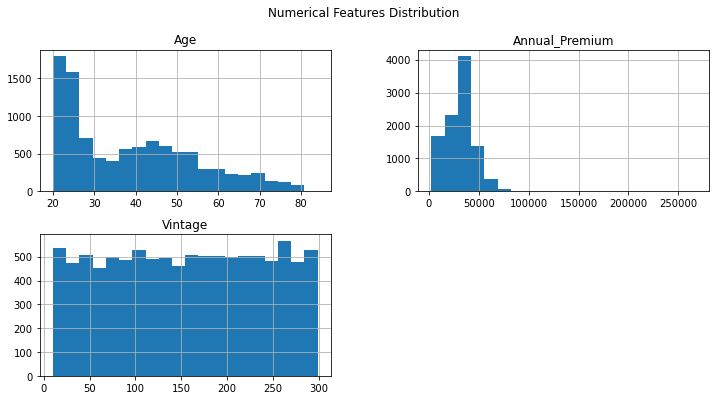

In [6]:
### Your code is here

num_features = ['Age', 'Annual_Premium', 'Vintage']
data[num_features].hist(bins=20, figsize=(12, 6))
plt.suptitle('Numerical Features Distribution')
plt.show()


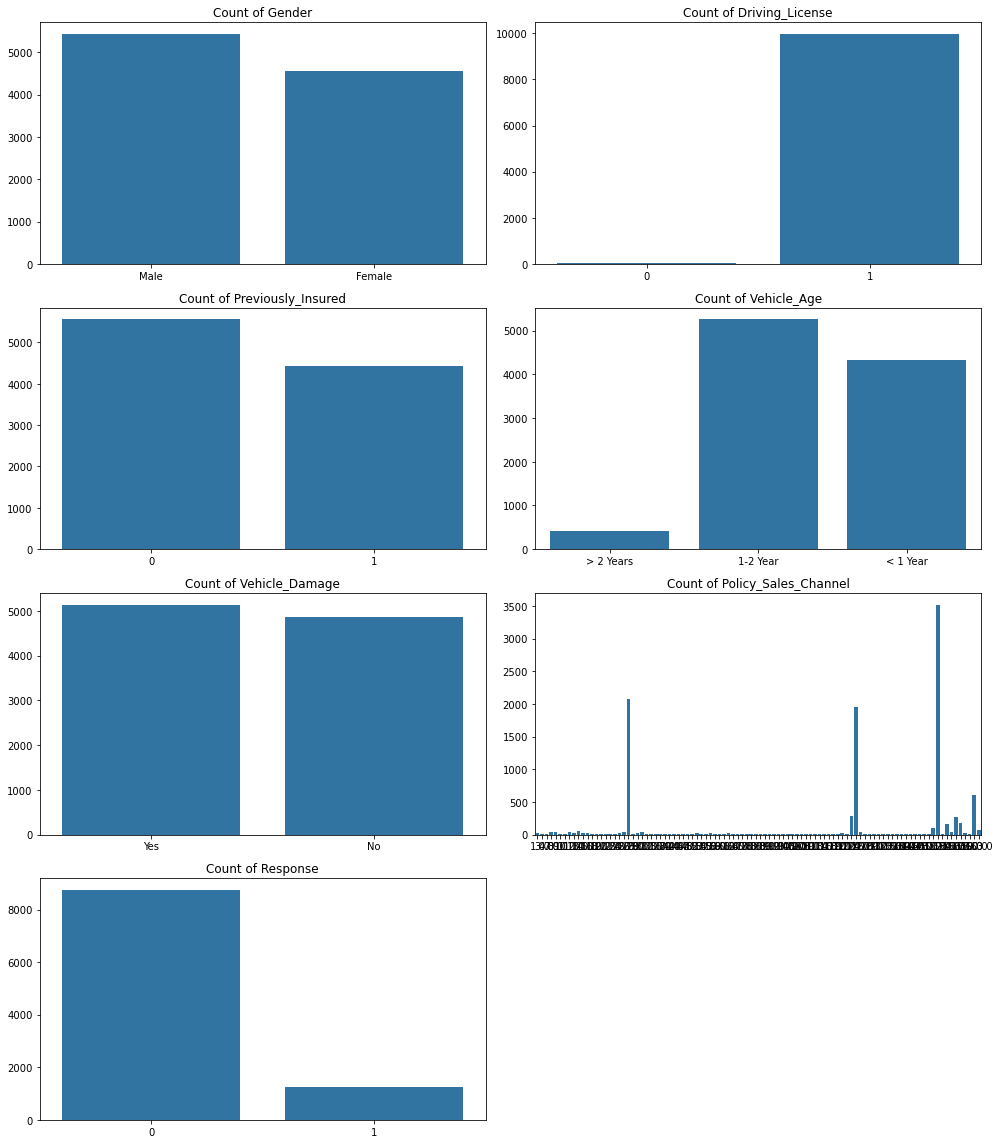

In [10]:
cat_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Response']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel("")  # Remove x-label for better readability
    axes[i].set_ylabel("")  # Remove y-label for better readability

# Hide extra subplots
for j in range(len(cat_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

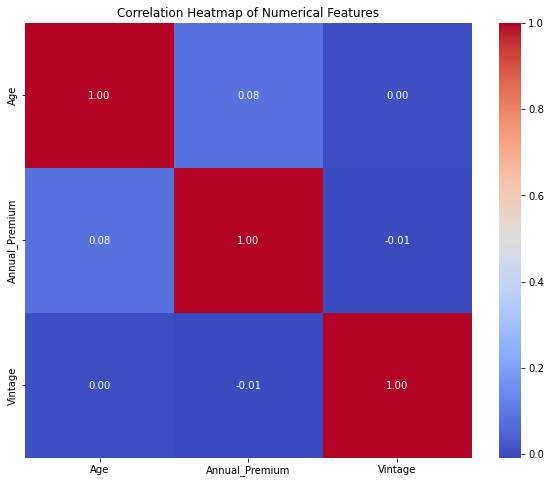

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

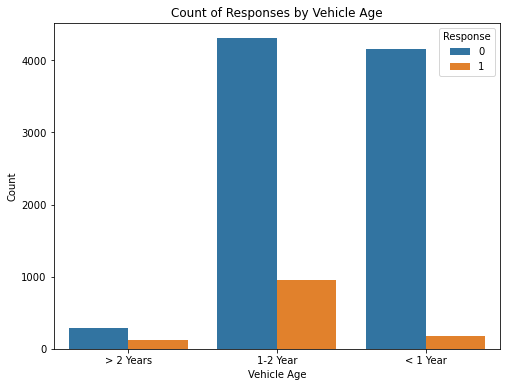

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Vehicle_Age', hue='Response')
plt.title('Count of Responses by Vehicle Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()


In [16]:
ohe_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
data = pd.get_dummies(data, columns=ohe_cols, drop_first=True)

**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1770
           1       0.31      0.24      0.27       230

    accuracy                           0.85      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.84      0.85      0.84      2000

F-score: 0.27
ROC-AUC: 0.828


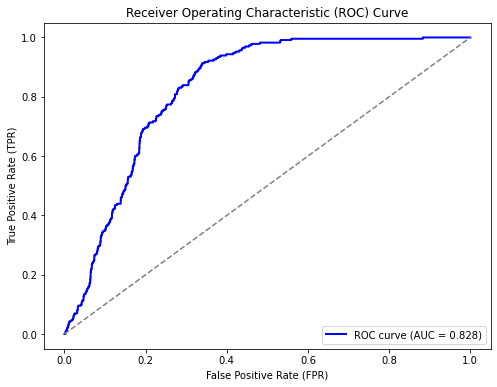

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

### Your code is here

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, random_state=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_prob = gb.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print(f"F-score: {round(f1_score(y_test, y_pred), 3)}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC: {round(roc_auc, 3)}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [33]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [34]:
### Your code is here
f1_scores = []

for n_est in n_estimators_list:
    f1_row = []

    for lr in learning_rate_list:
        gb = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        f1_row.append(f1)
    
    f1_scores.append(f1_row)

In [39]:
np.array(f1_scores).max().round(3)

0.846

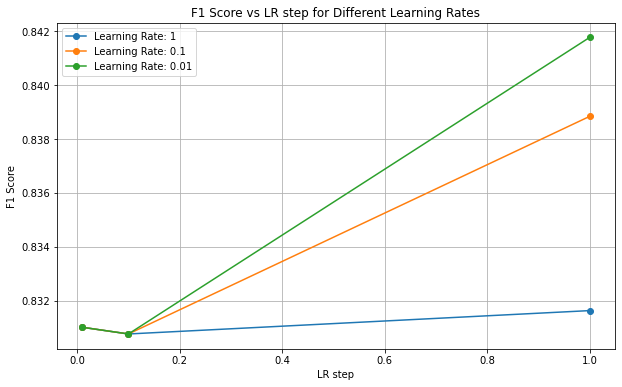

In [43]:
plt.figure(figsize=(10, 6))

for i, learning_rate in enumerate(learning_rate_list):
    plt.plot(learning_rate_list, f1_scores[i], label=f'Learning Rate: {learning_rate}', marker='o')

plt.xlabel('LR step')
plt.ylabel('F1 Score')
plt.title('F1 Score vs LR step for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [45]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

result = {}

### Your code is here
for max_depth in [5, 5000]:
    res = []
    for n_est in n_estimators_list:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_depth)
        
        print(f"Training Random Forest max_depth={max_depth} with {n_est} estimators")
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"F-score on test: {round(f1, 3)}")
        print("========================")
        res.append(round(f1, 3))
    result['rf_5'] = res

Training Random Forest max_depth=5 with 2 estimators
F-score on test: 0.83
Training Random Forest max_depth=5 with 3 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 4 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 5 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 10 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 20 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 50 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 70 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 100 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 200 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 700 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 1000 estimators
F-score on test: 0.831
Training Random Forest max_depth=5 with 2000 estimators
F-score on test: 0.8

In [46]:
for max_depth in [5, 5000]:
    res = []
    for n_est in n_estimators_list:
        gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth)
        
        print(f"Training Gradient Boosting max_depth={max_depth} with {n_est} estimators")
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"F-score on test: {round(f1, 3)}")
        print("========================")
        res.append(round(f1, 3))
    result['rf_5'] = res

Training Gradient Boosting max_depth=5 with 2 estimators
F-score on test: 0.831
Training Gradient Boosting max_depth=5 with 3 estimators
F-score on test: 0.831
Training Gradient Boosting max_depth=5 with 4 estimators
F-score on test: 0.832
Training Gradient Boosting max_depth=5 with 5 estimators
F-score on test: 0.832
Training Gradient Boosting max_depth=5 with 10 estimators
F-score on test: 0.832
Training Gradient Boosting max_depth=5 with 20 estimators
F-score on test: 0.832
Training Gradient Boosting max_depth=5 with 50 estimators
F-score on test: 0.831
Training Gradient Boosting max_depth=5 with 70 estimators
F-score on test: 0.835
Training Gradient Boosting max_depth=5 with 100 estimators
F-score on test: 0.837
Training Gradient Boosting max_depth=5 with 200 estimators
F-score on test: 0.843
Training Gradient Boosting max_depth=5 with 700 estimators
F-score on test: 0.843
Training Gradient Boosting max_depth=5 with 1000 estimators
F-score on test: 0.845
Training Gradient Boosting 

In [55]:
n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

results = {
    'rf_5': [],
    'rf_5000': [],
    'gb_5': [],
    'gb_5000': []
}

for n_est in n_estimators_list:
    rf_5 = RandomForestClassifier(n_estimators=n_est, max_depth=5)
    rf_5000 = RandomForestClassifier(n_estimators=n_est, max_depth=5000)
    gb_5 = GradientBoostingClassifier(n_estimators=n_est, max_depth=5)
    gb_5000 = GradientBoostingClassifier(n_estimators=n_est, max_depth=5000)

    for model_name, model in [('rf_5', rf_5), ('rf_5000', rf_5000), ('gb_5', gb_5), ('gb_5000', gb_5000)]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        f1 = f1_score(y_train, y_pred, average='weighted')
        print(model, f1)
        results[model_name].append(f1)


RandomForestClassifier(max_depth=5, n_estimators=2) 0.8172157635933118
RandomForestClassifier(max_depth=5000, n_estimators=2) 0.9305017719050087
GradientBoostingClassifier(max_depth=5, n_estimators=2) 0.813626927184142
GradientBoostingClassifier(max_depth=5000, n_estimators=2) 0.813626927184142
RandomForestClassifier(max_depth=5, n_estimators=3) 0.81531672340079
RandomForestClassifier(max_depth=5000, n_estimators=3) 0.9668517332785261
GradientBoostingClassifier(max_depth=5, n_estimators=3) 0.813626927184142
GradientBoostingClassifier(max_depth=5000, n_estimators=3) 0.813626927184142
RandomForestClassifier(max_depth=5, n_estimators=4) 0.8145376639440823
RandomForestClassifier(max_depth=5000, n_estimators=4) 0.9567887332251204
GradientBoostingClassifier(max_depth=5, n_estimators=4) 0.813626927184142
GradientBoostingClassifier(max_depth=5000, n_estimators=4) 0.813626927184142
RandomForestClassifier(max_depth=5, n_estimators=5) 0.813930988568076
RandomForestClassifier(max_depth=5000, n_est

In [60]:
results['gb_5']

[0.813626927184142,
 0.813626927184142,
 0.813626927184142,
 0.8142345670069886,
 0.8157452653412125,
 0.8184347539579007,
 0.8346382318375083,
 0.849979875567267,
 0.8722628949152541,
 0.920564290741731,
 0.9944551074442517,
 0.9993743417550238,
 1.0]

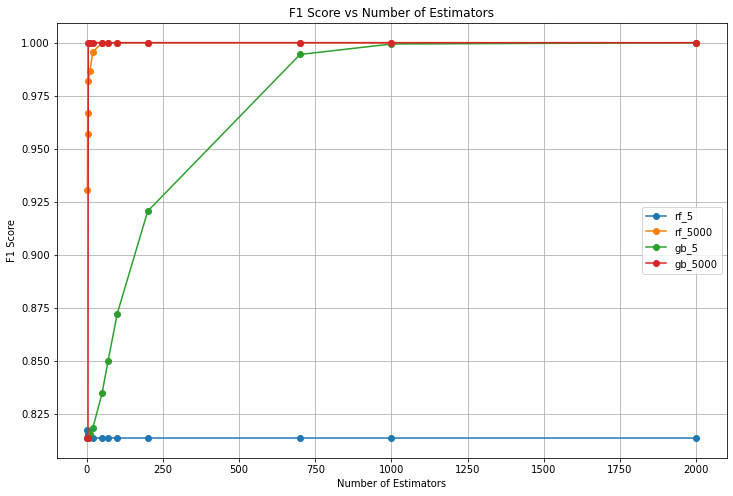

In [56]:
plt.figure(figsize=(12, 8))

for model_name, f1_scores in results.items():
    plt.plot(n_estimators_list, f1_scores, marker='o', label=model_name)

plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [61]:
from catboost import CatBoostClassifier

### Your code is here



ModuleNotFoundError: No module named 'catboost'

**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

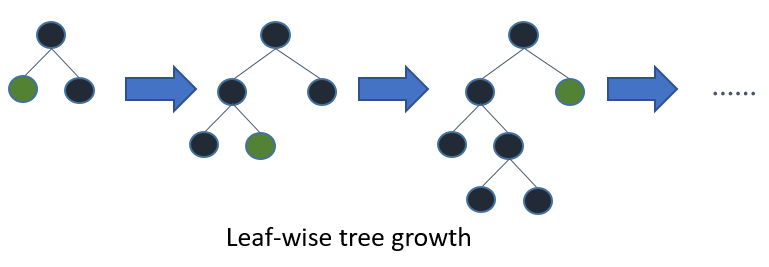

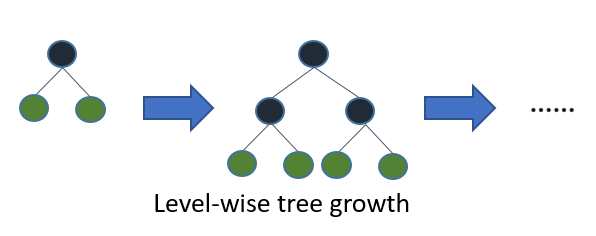

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

### Your code is here




In [3]:
df = pd.read_csv('data_challenge.csv')
df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,label
0,0.860224,1,0.905699,0.0,0.000000,0.897801,0.416134,0.936249,0.954516,0.655994,70.000000,0.904535,0.477965,1.000000,1
1,0.899660,0,0.950384,0.0,0.000000,0.899660,0.814271,0.965632,0.895718,0.866131,36.000000,0.726427,0.770299,1.000000,1
2,0.604478,0,0.901425,0.0,0.544263,0.816494,0.542276,0.929602,0.982845,0.943498,106.000000,0.855471,0.602923,0.670886,1
3,0.786914,0,0.874471,0.0,0.000000,0.767869,0.792423,0.901341,0.815631,0.793568,135.000000,0.843382,1.000000,1.000000,1
4,0.485634,1,0.909619,0.5,0.000000,0.499489,1.000000,0.644051,0.890473,0.998848,0.000000,0.825947,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280999,1.032293,0,0.627504,0.0,-0.934179,1.193713,-0.194791,0.725138,1.081494,1.357557,-91.817923,1.270148,1.932234,1.000000,1
281000,0.555958,0,0.686127,0.0,1.102023,0.346999,-0.271032,1.113987,0.702121,1.532698,189.935677,0.267263,1.784317,1.000000,0
281001,0.515235,0,0.672777,0.0,1.257941,1.193937,1.551960,1.092280,0.718573,0.430372,170.576421,1.229074,1.916109,1.000000,0
281002,0.497795,0,1.147425,0.0,-0.724074,0.334741,1.795984,1.050067,0.655956,0.323597,-73.464900,1.268021,-0.290214,1.000000,1


In [5]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,label
count,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000
mean,0.786245,0.085977,0.892915,0.132527,0.195575,0.773967,0.653034,0.884875,0.861789,0.863303,58.644184,0.758937,0.660080,0.914492,0.500160
std,0.089018,0.280331,0.083577,0.323653,0.303187,0.125954,0.248056,0.072949,0.190076,0.171181,67.475896,0.209225,0.257984,0.236541,0.500001
min,-0.063343,0.000000,0.427709,0.000000,-1.075384,-0.079069,-0.488159,0.128208,0.000000,-0.152368,-112.486216,0.000000,-0.649736,0.000000,0.000000
25%,0.738787,0.000000,0.848364,0.000000,0.000000,0.705784,0.464633,0.857066,0.856616,0.774144,20.000000,0.688354,0.461148,1.000000,0.000000
50%,0.796567,0.000000,0.908683,0.000000,0.000000,0.789394,0.626251,0.903768,0.912699,0.922107,42.000000,0.802971,0.628400,1.000000,1.000000
75%,0.846311,0.000000,0.953914,0.000000,0.434253,0.859719,0.849837,0.932482,0.945720,0.998507,73.000000,0.890945,0.910616,1.000000,1.000000
max,1.112313,1.000000,1.214537,1.000000,1.505117,1.240419,1.799994,1.119058,1.166633,1.559296,2676.000000,1.391272,2.020270,1.000000,1.000000


In [7]:
df.nunique()

col_0     280476
col_1          2
col_2      68464
col_3          3
col_4      76391
col_5     276645
col_6     132081
col_7     194348
col_8     193622
col_9      64567
col_10      2775
col_11     76938
col_12     56166
col_13      5524
label          2
dtype: int64

In [10]:
1, 1, 0, 0, 0
1, 1, 1, 0, 0
pr = 2 / 3
re = 1
f1 = (2 * pr * re) / (pr + re)

In [11]:
f1

0.8